In [1]:
from astropy.io import fits
import numpy as np
import astropy.time
import astropy.units as u
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import fnmatch

import sunpy.visualization.colormaps as cm

import glob
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Use glob to find more files
mdir='/scratch/mokusei/iain/rfia/hesperia.gsfc.nasa.gov/rhessi_extras/imagecube_fits/'
subdir='**/**/**/'
# mdir=''
ff=glob.glob(mdir+subdir+'**/hsi_imagecube_clean_*.fits')
print(len(ff))

6983


In [3]:
# archive names based on times not flare id
# want to find one from **/2012/10/26/20121026_0812_0818/hsi_imagecube_clean_20121026_0812_4tx3e.fits'
f0=fnmatch.filter(ff,'*20121026_0812*')
print(f0)

['/scratch/mokusei/iain/rfia/hesperia.gsfc.nasa.gov/rhessi_extras/imagecube_fits/2012/10/26/20121026_0812_0818/hsi_imagecube_clean_20121026_0812_4tx3e.fits']


In [4]:
#  Load in the data
fitsin=fits.open(f0[0])
imgs=fitsin[0].data
hdr=fitsin[0].header
nt,ne,nx,ny=imgs.shape
snr=fitsin[2].data['SNR_VALUE']
tims=fitsin[2].data['ABSOLUTE_TIME_RANGE']
engs=fitsin[2].data['IM_EBAND_USED']
fitsin.close()

# sort out the times
ref79=astropy.time.Time('1979-01-01 00:00:00',format='iso',scale='tai')
times=ref79+tims*u.s

# Sort out the time labels
timlab=[]
for t in np.arange(nt):
    timlab.append(times[t*ne][0].isot[11:19]+' - '+times[t*ne][1].isot[11:19])
# Sort out the energy labels
englab=[]
for ee in np.arange(ne):
    englab.append(str(engs[ee][0])+' - '+str(engs[ee][1])+' keV')

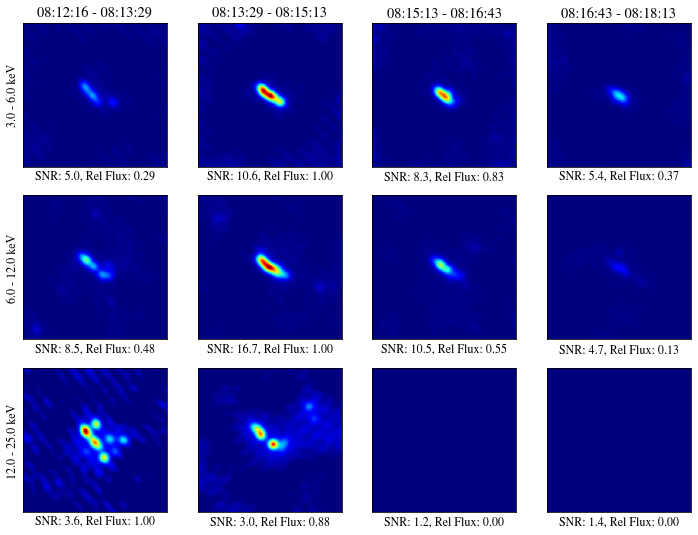

In [5]:
# Work out the Max per enery for scaling
# maxs=[,np.max(imgs[:,1,:,:]),np.max(imgs[:,2,:,:])]
maxs=np.zeros(ne)
for ee in np.arange(ne):
    maxs[ee]=np.max(imgs[:,ee,:,:])
# Work out the Rel Flux for each one
relflux=np.zeros(shape=(nt,ne))
for tt in np.arange(nt):
    for ee in np.arange(ne):
        relflux[tt,ee]=np.max(imgs[tt,ee,:,:])/maxs[ee]

# Plot all the maps    
plt.rcParams.update({'font.size': 12,'font.family':"serif",\
                      'font.serif':"STIXGeneral",'mathtext.default':"regular"})
fig, ax = plt.subplots(nrows=ne, ncols=nt,figsize=(nt*3, ne*3))
# Load in the RHESSI color table (maybe not the best here?)
cmap = plt.get_cmap('rhessi')
# Loop over all the maps and plot
for tt in np.arange(nt):
    for ee in np.arange(ne):
        ax[ee,tt].set_xticks([])
        ax[ee,tt].set_yticks([])
        ax[ee,tt].imshow(imgs[tt,ee,:,:],origin='lower',vmin=0.,vmax=maxs[ee],cmap=cmap)
        if (ee == 0):
            ax[ee,tt].set_title(timlab[tt])
        if (tt == 0):
            ax[ee,tt].set_ylabel(englab[ee]) 
        ax[ee,tt].set_xlabel('SNR: '+"%0.1f" % snr[tt*ne+ee]+\
                             ', Rel Flux: '+"%0.2f" % relflux[tt,ee])    
plt.show()

In [6]:
# What one do we want for the "thermal" and "non-thermal" images?
# Just manually assign them here
idtt=1
idte=1
idnt=1
idne=2

print('Thermal: '+timlab[idtt]+', '+englab[idte])
print('Non-Thermal: '+timlab[idnt]+', '+englab[idne])

imgth=imgs[idtt,idte,:,:]
maxth=np.max(imgth)
imgnt=imgs[idnt,idne,:,:]
maxnt=np.max(imgnt)

Thermal: 08:13:29 - 08:15:13, 6.0 - 12.0 keV
Non-Thermal: 08:13:29 - 08:15:13, 12.0 - 25.0 keV


In [7]:
# Let's say we have defined this as class A
img_class='A'

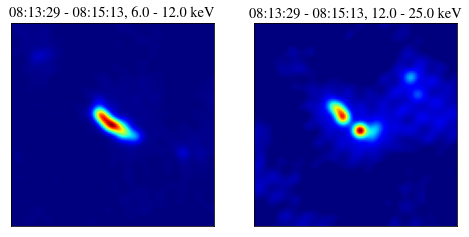

In [8]:
# Plot all the maps    
plt.rcParams.update({'font.size': 12,'font.family':"serif",\
                      'font.serif':"STIXGeneral",'mathtext.default':"regular"})
fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(2*4, 1*4))
# Load in the RHESSI color table (maybe not the best here?)
cmap = plt.get_cmap('rhessi')

ax[0].imshow(imgth/maxth,origin='lower',vmin=0.,vmax=1,cmap=cmap)
ax[1].imshow(imgnt/maxnt,origin='lower',vmin=0.,vmax=1,cmap=cmap)
ax[0].set_xticks([])
ax[1].set_xticks([])
ax[0].set_yticks([])
ax[1].set_yticks([])
ax[0].set_title(timlab[idtt]+', '+englab[idte])
ax[1].set_title(timlab[idnt]+', '+englab[idne])  
plt.show()

In [9]:
imgthout=imgth/maxth
imgthout[imgthout < 0]=0
imgntout=imgnt/maxnt
imgntout[imgntout < 0]=0

outdata=np.array([imgthout,imgntout], dtype=np.float)
hduout=fits.PrimaryHDU(outdata)
# What's the stuff to add?
hduout.header['DATE_OBS']=hdr['DATE_OBS']
hduout.header['CDELT1']=hdr['CDELT1']
hduout.header['CDELT2']=hdr['CDELT2']
hduout.header['XCEN']=hdr['XCEN']
hduout.header['YCEN']=hdr['YCEN']
hduout.header['TIME_TH']=timlab[idtt]
hduout.header['ENERGY_TH']=englab[idte]
hduout.header['TIME_NT']=timlab[idnt]
hduout.header['ENERGY_NT']=englab[idne]
hduout.header['IMG_CLASS']=img_class
hduout.header['MAX_TH']=maxth
hduout.header['MAX_NT']=maxnt
ids=str.find(f0[0],'hsi_image')
afname=f0[0][ids:]
hduout.header['ARCHIVE_FNAME']=afname

In [10]:
# Save it all out....
ids2=str.find(afname,'clean_')
foutname=img_class+afname[ids2+5:ids2+19]+'.fits'
odir='/scratch/mokusei/iain/rfia/training_set/'
hduout.writeto(odir+foutname,overwrite='True')

In [11]:
# Try loading it back in to see what happens
rfits=fits.open(odir+foutname)
rimgs=rfits[0].data
rhdr=rfits[0].header
rfits.close()

In [12]:
# Did it work.....
print(rimgs.shape)
for keys in rhdr:
    print(keys,': ',rhdr[keys])

(2, 101, 101)
SIMPLE :  True
BITPIX :  -64
NAXIS :  3
NAXIS1 :  101
NAXIS2 :  101
NAXIS3 :  2
EXTEND :  True
DATE_OBS :  2012-10-26T08:12:16.200
CDELT1 :  1.5
CDELT2 :  1.5
XCEN :  -215.556
YCEN :  -261.945
TIME_TH :  08:13:29 - 08:15:13
ENERGY_TH :  6.0 - 12.0 keV
TIME_NT :  08:13:29 - 08:15:13
ENERGY_NT :  12.0 - 25.0 keV
IMG_CLASS :  A
MAX_TH :  0.5511888265609741
MAX_NT :  0.0140162380412221
ARCHIVE_FNAME :  hsi_imagecube_clean_20121026_0812_4tx3e.fits


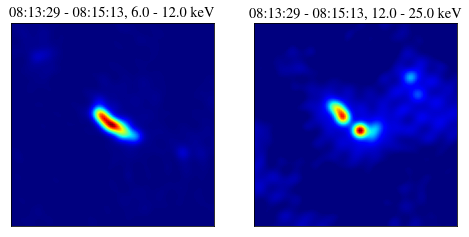

In [13]:
# Plot the reloaded maps     
plt.rcParams.update({'font.size': 12,'font.family':"serif",\
                      'font.serif':"STIXGeneral",'mathtext.default':"regular"})
fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(2*4, 1*4))
cmap = plt.get_cmap('rhessi')
ax[0].imshow(rimgs[0,:,:],origin='lower',vmin=0.,vmax=1,cmap=cmap)
ax[1].imshow(rimgs[1,:,:],origin='lower',vmin=0.,vmax=1,cmap=cmap)
ax[0].set_xticks([])
ax[1].set_xticks([])
ax[0].set_yticks([])
ax[1].set_yticks([])
ax[0].set_title(rhdr['time_th']+', '+rhdr['energy_th'])
ax[1].set_title(rhdr['time_nt']+', '+rhdr['energy_nt'])  
plt.show()